<a href="https://colab.research.google.com/github/klimanyusuf/Resource_demand_prediction-_and_Allocation/blob/main/resource_alloc_helium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preprocessing and Data integration

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#load data
from google.colab import drive
drive.mount('/content/drive')

patient_demo = pd.read_excel("/content/drive/MyDrive/case study data/Patient_Demo.xlsx")
hospital_visits = pd.read_excel("/content/drive/MyDrive/case study data/Patient_Hospital_Visit.xlsx")

Mounted at /content/drive


In [3]:
#check for missing values
patient_demo.isnull().sum()

,0
institution_id,0
patient_id,0
dob,169
sex,170
state,36771


In [4]:
#check for missing values
hospital_visits.isnull().sum()

,0
visit_id,0
patient_id,0
institution_id,0
admitted_at,430614
discharged_at,430514
inserted_at,0
visit_type,0
facility_type,0


In [5]:

# Convert dates to datetime
patient_demo['dob'] = pd.to_datetime(patient_demo['dob'], errors='coerce')
hospital_visits['admitted_at'] = pd.to_datetime(hospital_visits['admitted_at'], errors='coerce')
hospital_visits['discharged_at'] = pd.to_datetime(hospital_visits['discharged_at'], errors='coerce')

# Calculate age
patient_demo['age'] = (pd.Timestamp.now() - patient_demo['dob']).dt.days // 365

# Remove missing demographic data
patient_demo = patient_demo.dropna(subset=['dob', 'sex'])

# Filter in-patient records and calculate length of stay
hospital_visits['length_of_stay'] = (hospital_visits['discharged_at'] -
                                     hospital_visits['admitted_at']).dt.days
filtered_visits = hospital_visits[~hospital_visits['visit_type'].str.contains("out-patient", na=False)]

# Merge datasets
merged_data = pd.merge(filtered_visits, patient_demo, on='patient_id', how='inner')

# Create visit frequency
visit_frequency = merged_data.groupby('patient_id')['visit_id'].count().reset_index()
visit_frequency.columns = ['patient_id', 'visit_frequency']
merged_data = pd.merge(merged_data, visit_frequency, on='patient_id', how='left')


In [6]:
#view the preprocessed data
merged_data.head()

,visit_id,patient_id,institution_id_x,admitted_at,discharged_at,inserted_at,visit_type,facility_type,length_of_stay,institution_id_y,dob,sex,state,age,visit_frequency
0,8b802ab0-aee6-4ac2-92b9-15cab3de8969,PEBEZUQ42,9db63f62-5c58-4303-919e-e23681909271,2021-07-08 15:05:44,2021-07-19 14:07:51,2021-07-08,in-patient,hospital,10.0,9db63f62-5c58-4303-919e-e23681909271,1967-03-03,male,ogunstate,57.0,1
1,a4b35839-77cf-437d-b7eb-81aa32ccab39,X8FC4CD7X,d1ec3213-ae35-4ab3-b45f-72feca0fd5f3,2021-06-17 07:37:13,2021-07-04 13:27:35,2021-06-17,in-patient,hospital,17.0,d1ec3213-ae35-4ab3-b45f-72feca0fd5f3,1984-05-07,male,NaN,40.0,1
2,07a28bc5-bb1e-4d0c-9b84-206926af6b58,74WNJNFRQ,f7427dbb-e87d-4ed2-b168-136c244596b2,2021-06-01 20:43:26,2021-06-04 16:38:25,2021-06-01,in-patient,hospital,2.0,f7427dbb-e87d-4ed2-b168-136c244596b2,2001-04-04,male,0ndo,23.0,1
3,24b88458-2f0f-4e22-951f-cf46f587b228,JB8T7XEDS,4850e9c9-2945-4087-b4f9-6c302e44b84e,2021-07-08 16:44:03,2021-07-11 06:10:30,2021-07-08,in-patient,hospital,2.0,4850e9c9-2945-4087-b4f9-6c302e44b84e,1997-10-14,female,kano,27.0,1
4,8a58a82f-9dfc-4fe8-bc43-a9434eb2232b,NX9DPQY34,157af2f9-073d-4d75-89e0-b6d214c6d05e,2021-10-24 06:06:51,2021-10-25 15:59:34,2021-10-24,in-patient,hospital,1.0,157af2f9-073d-4d75-89e0-b6d214c6d05e,1996-08-18,female,ENUGU STATE,28.0,1


#2. Feature Engineering

In [7]:
# Create age groups
bins = [0, 18, 35, 50, 65, 80, 120]
labels = ['0-17', '18-34', '35-49', '50-64', '65-79', '80+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)

# Add month of admission for temporal analysis
merged_data['admitted_month'] = merged_data['admitted_at'].dt.to_period("M")

# Assign resource demand categories based on length of stay
conditions = [
    merged_data['length_of_stay'] <= 2,
    merged_data['length_of_stay'].between(3, 7, inclusive="both"),
    merged_data['length_of_stay'] > 7
]
choices = ['low', 'medium', 'high']
merged_data['resource_demand'] = np.select(conditions, choices, default='low')


In [8]:
merged_data.head()

,visit_id,patient_id,institution_id_x,admitted_at,discharged_at,inserted_at,visit_type,facility_type,length_of_stay,institution_id_y,dob,sex,state,age,visit_frequency,age_group,admitted_month,resource_demand
0,8b802ab0-aee6-4ac2-92b9-15cab3de8969,PEBEZUQ42,9db63f62-5c58-4303-919e-e23681909271,2021-07-08 15:05:44,2021-07-19 14:07:51,2021-07-08,in-patient,hospital,10.0,9db63f62-5c58-4303-919e-e23681909271,1967-03-03,male,ogunstate,57.0,1,50-64,2021-07,high
1,a4b35839-77cf-437d-b7eb-81aa32ccab39,X8FC4CD7X,d1ec3213-ae35-4ab3-b45f-72feca0fd5f3,2021-06-17 07:37:13,2021-07-04 13:27:35,2021-06-17,in-patient,hospital,17.0,d1ec3213-ae35-4ab3-b45f-72feca0fd5f3,1984-05-07,male,NaN,40.0,1,35-49,2021-06,high
2,07a28bc5-bb1e-4d0c-9b84-206926af6b58,74WNJNFRQ,f7427dbb-e87d-4ed2-b168-136c244596b2,2021-06-01 20:43:26,2021-06-04 16:38:25,2021-06-01,in-patient,hospital,2.0,f7427dbb-e87d-4ed2-b168-136c244596b2,2001-04-04,male,0ndo,23.0,1,18-34,2021-06,low
3,24b88458-2f0f-4e22-951f-cf46f587b228,JB8T7XEDS,4850e9c9-2945-4087-b4f9-6c302e44b84e,2021-07-08 16:44:03,2021-07-11 06:10:30,2021-07-08,in-patient,hospital,2.0,4850e9c9-2945-4087-b4f9-6c302e44b84e,1997-10-14,female,kano,27.0,1,18-34,2021-07,low
4,8a58a82f-9dfc-4fe8-bc43-a9434eb2232b,NX9DPQY34,157af2f9-073d-4d75-89e0-b6d214c6d05e,2021-10-24 06:06:51,2021-10-25 15:59:34,2021-10-24,in-patient,hospital,1.0,157af2f9-073d-4d75-89e0-b6d214c6d05e,1996-08-18,female,ENUGU STATE,28.0,1,18-34,2021-10,low


#3. Exploratory Data Analysis

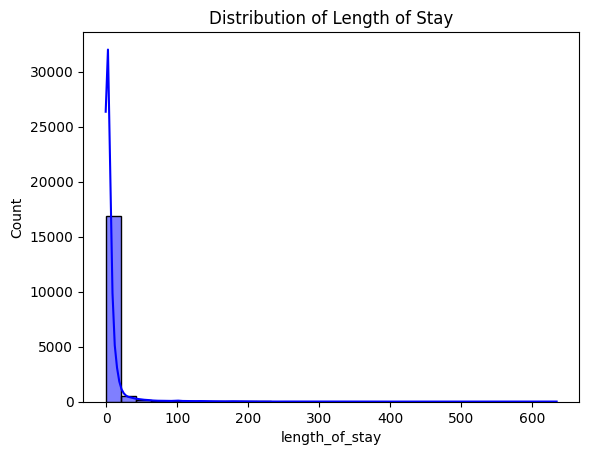

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Length of Stay
sns.histplot(merged_data['length_of_stay'].dropna(), kde=True, bins=30, color="blue")
plt.title("Distribution of Length of Stay")
plt.show()

**Insights:**
*   Most patients have shorter stays, while a smaller number of patients have longer stays that extend the tail of the distribution.



<ipython-input-10-252393f7c4e2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_data, x='resource_demand', palette='cool')


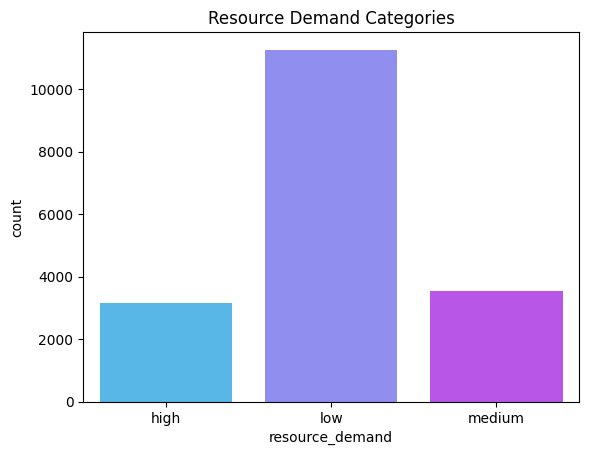

In [10]:
# Resource Demand Distribution
sns.countplot(data=merged_data, x='resource_demand', palette='cool')
plt.title("Resource Demand Categories")
plt.show()

**interpretation**

Resourcee=s demand categories:

*   Low: Patients with a length of stay of 2 days or less
*   Medium: Patients with a length of stay between 3
*   High: Patients with a length of stay greater than 7 days

**Insights**
*   Majority of patients have a shorter length of stay and fall into the low resource demand category. Hence they need low resources.





**insights**



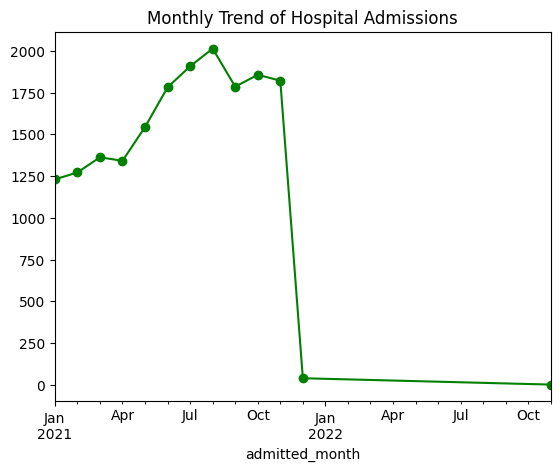

In [11]:
# Monthly Trend of Admissions
monthly_trends = merged_data.groupby('admitted_month').size()
monthly_trends.plot(kind='line', marker='o', color="green")
plt.title("Monthly Trend of Hospital Admissions")
plt.show()

In [12]:
merged_data.columns

Index(['visit_id', 'patient_id', 'institution_id_x', 'admitted_at',
       'discharged_at', 'inserted_at', 'visit_type', 'facility_type',
       'length_of_stay', 'institution_id_y', 'dob', 'sex', 'state', 'age',
       'visit_frequency', 'age_group', 'admitted_month', 'resource_demand'],
      dtype='object')

# 4. Predictive Model

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Select features and target
features = ['age', 'visit_frequency', 'facility_type']

# Dynamically identify and handle missing columns for get_dummies
categorical_cols = ['facility_type', 'sex', 'state']  # Columns intended for dummies
columns_to_dummy = [col for col in categorical_cols if col in merged_data.columns]
merged_data = pd.get_dummies(merged_data, columns=columns_to_dummy, drop_first=True)

# Adjust features if necessary based on available columns
features = [f for f in features if f in merged_data.columns]
X = merged_data[features]
y = merged_data['resource_demand']

# Encode target variable
y = y.map({'low': 0, 'medium': 1, 'high': 2})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6142061281337048
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.92      0.77      2232
           1       0.23      0.03      0.05       758
           2       0.35      0.20      0.26       600

    accuracy                           0.61      3590
   macro avg       0.41      0.38      0.36      3590
weighted avg       0.51      0.61      0.53      3590



**Optimising the model**

In [21]:
!pip install imblearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE  # For handling class imbalance

# ... (previous code for data preparation and feature selection)

# Handle class imbalance using SMOTE (oversampling)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest Classifier with resampled data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5311977715877437
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69      2232
           1       0.24      0.19      0.21       758
           2       0.30      0.42      0.35       600

    accuracy                           0.53      3590
   macro avg       0.42      0.43      0.42      3590
weighted avg       0.54      0.53      0.53      3590



In [38]:
y_pred

array([0, 2, 0, ..., 0, 0, 0])

#5. Resource Allocation Optimization:

**1. Decision Support Tool**

*   Inputs:

Predicted demand values.

Facility-specific resource constraints.

Cost matrix (distance or other allocation costs)

*   Outputs:

Optimal allocation matrix.

Total cost of allocation.

Alerts for unmet demand or resource shortages.

**2. Implementation:**
*   Build a dashboard using Streamlit or Dash.
*   Provide interactive inputs for resource and demand values.
* Display allocation results, bottlenecks, and costs in real-time.

**3. Guidelines for Deployment**

* Integration: Integrate the optimization model with demand prediction outputs.
* Use real-time data streams for dynamic allocation updates.

**4. Validation:**

* Validate the algorithm using historical data and simulated scenarios.
* Ensure the model adheres to healthcare regulations and stakeholder requirements.
Scalability:

**5. Scalability**
* Optimize algorithm efficiency for large-scale
 problems.
* Leverage cloud-based solutions (e.g., AWS or GCP) for computation.

**6. Stakeholder Involvement:**
* Engage healthcare providers and administrators in defining constraints and objectives.
* Provide interpretable outputs to build trust in recommendations.


**Allocation Algorithm**

In [52]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# data input
facilities = ['Facility_A', 'Facility_B', 'Facility_C']
locations = ['Location_X', 'Location_Y', 'Location_Z']

# Resources available at each facility
resources = [100, 200, 150]

# Predicted demand at each location
demand = [120, 180, 150]

# Cost matrix (e.g., distance or allocation cost)
cost_matrix = [
    [2, 4, 5],  # Costs from Facility_A
    [3, 1, 7],  # Costs from Facility_B
    [6, 5, 3]   # Costs from Facility_C
]

# Create optimization problem
problem = LpProblem("Resource_Allocation", LpMinimize)

# Decision variables
allocation = {
    (i, j): LpVariable(f"x_{i}_{j}", lowBound=0, cat="Continuous")
    for i in range(len(facilities))
    for j in range(len(locations))
}

# Objective function: Minimize cost
problem += lpSum(
    cost_matrix[i][j] * allocation[i, j]
    for i in range(len(facilities))
    for j in range(len(locations))
)

# Constraints: Meet demand at each location
for j in range(len(locations)):
    problem += lpSum(allocation[i, j] for i in range(len(facilities))) >= demand[j], f"Demand_{j}"

# Constraints: Do not exceed resources at each facility
for i in range(len(facilities)):
    problem += lpSum(allocation[i, j] for j in range(len(locations))) <= resources[i], f"Resource_{i}"

# Solve the problem
problem.solve()

# Output results
print("Optimal Allocation:")
for i in range(len(facilities)):
    for j in range(len(locations)):
        print(f"{facilities[i]} to {locations[j]}: {allocation[i, j].varValue:.2f}")

print("\nTotal Cost:", problem.objective.value())


Optimal Allocation:
Facility_A to Location_X: 100.00
Facility_A to Location_Y: 0.00
Facility_A to Location_Z: 0.00
Facility_B to Location_X: 20.00
Facility_B to Location_Y: 180.00
Facility_B to Location_Z: 0.00
Facility_C to Location_X: 0.00
Facility_C to Location_Y: 0.00
Facility_C to Location_Z: 150.00

Total Cost: 890.0


#6. Model Interpretability and Explainability

In [23]:
 pip install shap

100%|===================| 10721/10770 [01:33<00:00]       

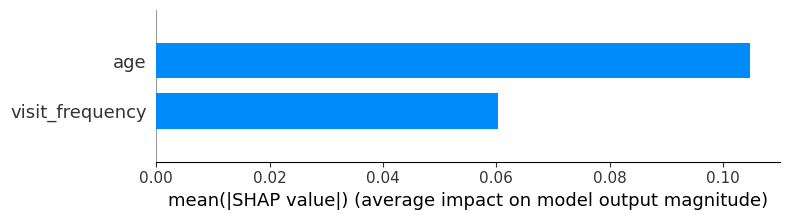

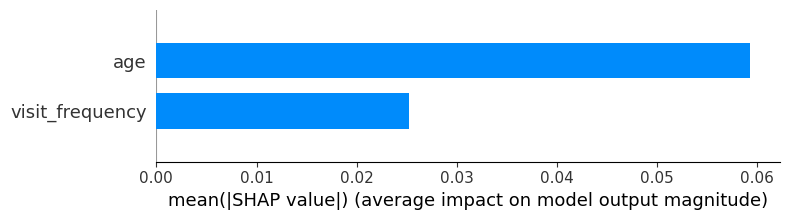

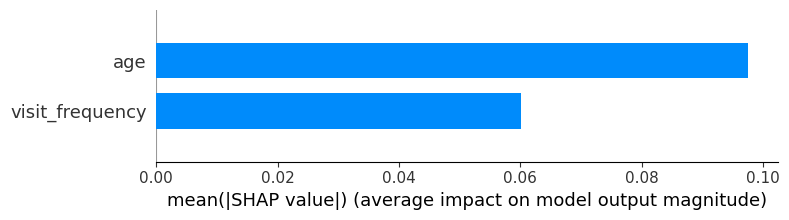

In [26]:
import shap

# Initialize SHAP Explainer for Random Forest
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary Plot for Feature Importance (modified for multi-class)
# Loop through each class and create a separate summary plot
for i in range(shap_values.shape[2]):  # Assuming 3 classes
    shap.summary_plot(shap_values[:, :, i], X_test, plot_type="bar", title=f"Class {i}")


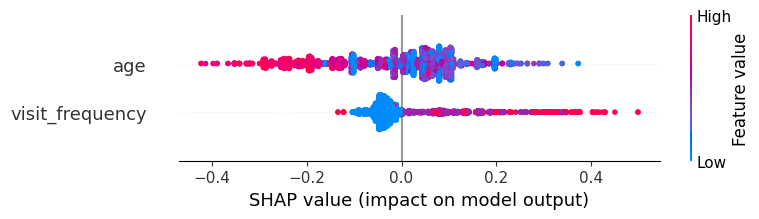

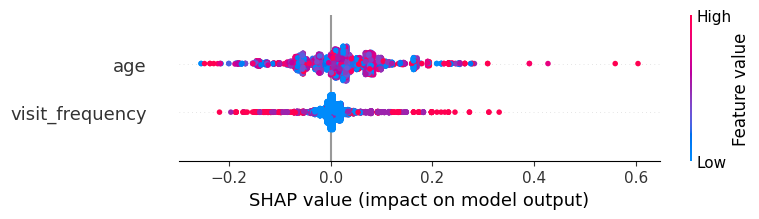

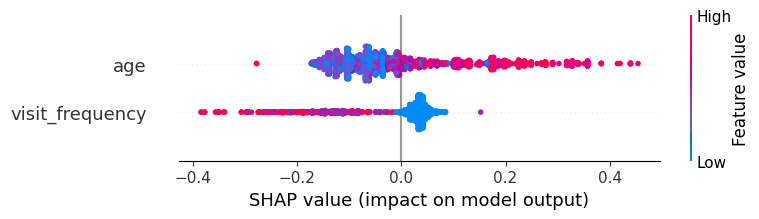

In [27]:
# Detailed SHAP Summary Plot (modified for multi-class)
# Loop through each class and create a separate summary plot
for i in range(shap_values.shape[2]):  # Assuming 3 classes
    shap.summary_plot(shap_values[:, :, i], X_test, title=f"Class {i}")

<ipython-input-28-6511331ea227>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


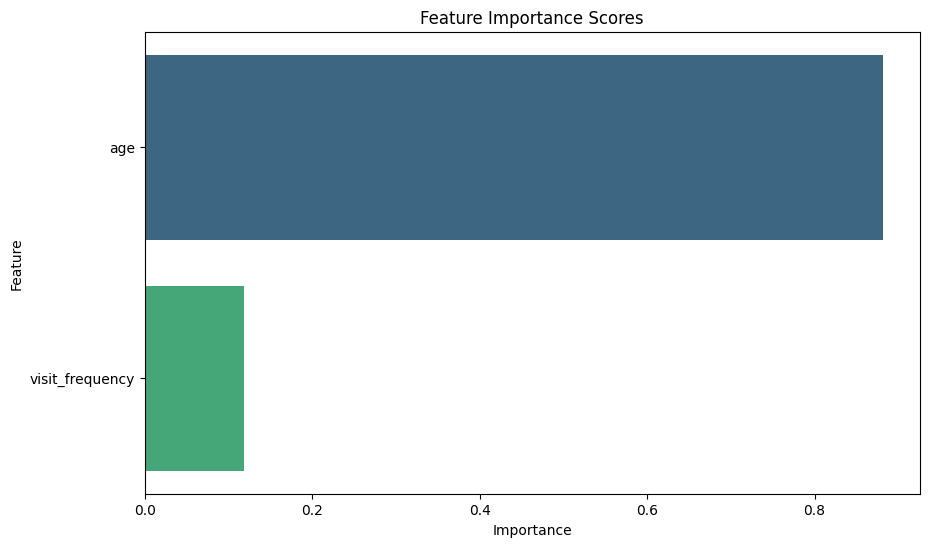

In [28]:
# Extract feature importance
importance = model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance Scores")
plt.show()


#7. Model Interpretation and Recommendation

**1. Interpretation**:

* The features that impacted resource demand the most are both age and frequesncy of visit by the patients. Meaning older people tend to come to the hospital more require more resource because the stay longer
*   Age has the highest feature inportance level. This means, Age is the strongest driver for resource demand. Older people tend to visit more require more resource because the stay longer.
* Older patients tend to have more complex healthcare needs. They might have multiple chronic conditions that require longer hospital stays


**2. Recommendation**:

**Resource Planning**:
* Allocate more resources to departments or facilities that primarily serve older populations.
* Develop specialized care pathways or programs for elderly patients
* Ensure adequate staffing levels to meet the needs of older patients

**Individualized Care**:
* Doctors and nurses can consider a patient's age as a significant factor when assessing their potential resource requirements. This could help in:
* Tailoring treatment plans to better address age-related health concerns.
* Having earlier conversations about potential discharge planning and support services for older patients.
* Proactively managing potential complications that are more common in older adults

 # 8. Deployment Plan

To deploy the model:

Save the trained model using joblib or pickle.
Develop a REST API using a framework like Flask or FastAPI.
Integrate the API into the Health EMR system for real-time predictions.


# 9. Monitoring
Monitor the model for:

Data drift using statistical checks.
Performance metrics like accuracy and class-wise recall.
Automated retraining pipelines for periodic updates.

# 10. Scalability
**bold text**
* Optimize algorithm efficiency for large-scale problems.
* Leverage cloud-based solutions (e.g., AWS or GCP) for computation